In [ ]:
# import all libraries
import itertools, cv2, os, time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MinMaxScaler

import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB6, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input
from tensorflow.keras.layers import InputLayer, Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from sklearn.metrics import plot_confusion_matrix

from glob import glob

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# for accuracy
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') >= 0.99:
                print('\nReached 99% accuracy so cancelling training!')
                self.model.stop_training=True
                
callbacks = myCallback()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

### **Train on balanced dataest**

In [ ]:
lung_dir='../content/gdrive/MyDrive/lung_data_full/'
lung_aca='../content/gdrive/MyDrive/lung_data_full/lung_aca/'
lung_n='../content/gdrive/MyDrive/lung_data_full/lung_n/'
lung_scc='../content/gdrive/MyDrive/lung_data_full/lung_scc/'

In [ ]:
%%time
train_aca_names = os.listdir(lung_aca)
print(f'TRAIN SET ADENOCARCINOMA: {train_aca_names[:10]}')
print('\n')

train_n_names = os.listdir(lung_n)
print(f'TRAIN SET BENIGN: {train_n_names[:10]}')
print('\n')

train_scc_names = os.listdir(lung_scc)
print(f'TRAIN SET SQUAMOS CELL CARCINOMA: {train_scc_names[:10]}')

TRAIN SET ADENOCARCINOMA: ['lungaca725.jpeg', 'lungaca734.jpeg', 'lungaca751.jpeg', 'lungaca724.jpeg', 'lungaca720.jpeg', 'lungaca746.jpeg', 'lungaca715.jpeg', 'lungaca759.jpeg', 'lungaca771.jpeg', 'lungaca765.jpeg']


TRAIN SET BENIGN: ['lungn3903.jpeg', 'lungn3981.jpeg', 'lungn3983.jpeg', 'lungn3939.jpeg', 'lungn3987.jpeg', 'lungn3992.jpeg', 'lungn3906.jpeg', 'lungn3994.jpeg', 'lungn4007.jpeg', 'lungn3980.jpeg']


TRAIN SET SQUAMOS CELL CARCINOMA: ['lungscc2.jpeg', 'lungscc64.jpeg', 'lungscc39.jpeg', 'lungscc19.jpeg', 'lungscc55.jpeg', 'lungscc53.jpeg', 'lungscc32.jpeg', 'lungscc24.jpeg', 'lungscc50.jpeg', 'lungscc18.jpeg']
CPU times: user 165 ms, sys: 22.9 ms, total: 188 ms
Wall time: 49.1 s


In [ ]:
print(f'total training Adenocarcinoma images: {len(os.listdir(lung_aca))}')
print(f'total training Benign images: {len(os.listdir(lung_n))}')
print(f'total training Squamous Cell Carcinoma images: {len(os.listdir(lung_scc))}')

# calculate number of training images
train_aca = len(os.listdir(lung_aca))
train_n = len(os.listdir(lung_n))
train_scc = len(os.listdir(lung_scc))
total = train_aca + train_n + train_scc

# print total number of images
print('Total Images in dataset: %s' % str((total))) 

total training Adenocarcinoma images: 4972
total training Benign images: 5000
total training Squamous Cell Carcinoma images: 5000
Total Images in dataset: 14972


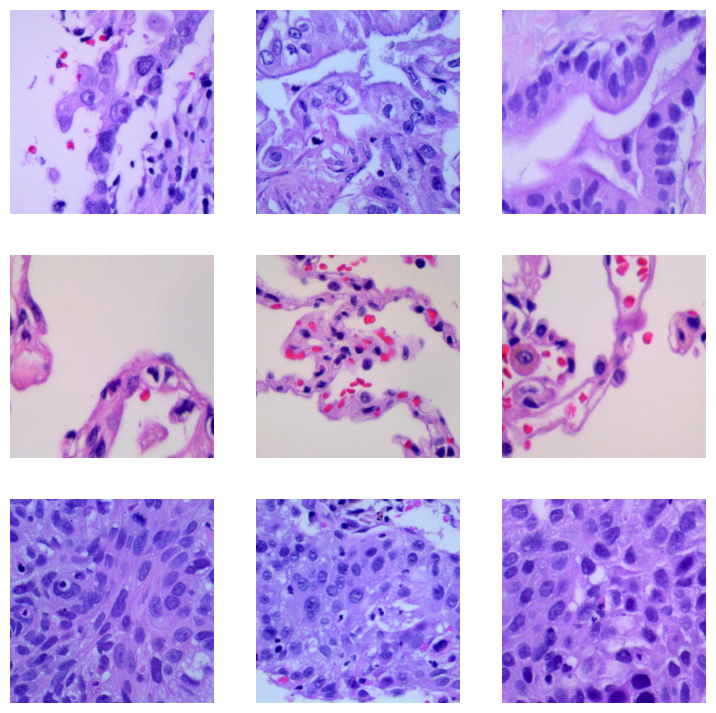

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 3
ncols = 3

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

pic_index += 3
next_aca_pix = [os.path.join(lung_aca, fname) 
                for fname in train_aca_names[pic_index-3:pic_index]]

next_scc_pix = [os.path.join(lung_scc, fname) 
                for fname in train_scc_names[pic_index-3:pic_index]]

next_n_pix = [os.path.join(lung_n, fname) 
                for fname in train_n_names[pic_index-3:pic_index]]

for i, img_path in enumerate(next_aca_pix + next_n_pix + next_scc_pix):
    
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
%%time

data_dir = '/content/gdrive/MyDrive/lung_data_full/'

# making a data split of 80-20
data = ImageDataGenerator(validation_split = 0.2)

# setting up the batch size
BATCH_SIZE = 128

# setting up the image size
X = Y = 224

# making training dataset
train_data = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

# making validation dataset
val_data = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 11978 images belonging to 3 classes.
Found 2994 images belonging to 3 classes.
CPU times: user 318 ms, sys: 123 ms, total: 441 ms
Wall time: 609 ms


In [ ]:
# print label names
label =  {0: "lung adenocarcinoma", 1: "benign", 2: "squamous cell carcinoma"}
for t in label.keys():
    print(t, label[t])

0 lung adenocarcinoma
1 benign
2 squamous cell carcinoma


In [ ]:
# print label names
label =  {0: "lung adenocarcinoma", 1: "benign", 2: "squamous cell carcinoma"}
for t in label.keys():
    print(t, label[t])

# initializing efficientnet b7 cnn model
eff_5 = EfficientNetB5 (
        input_shape=(X, Y, 3),
        weights='imagenet',
        include_top=False
        )

# setting trainable to false    
eff_5.trainable = False

# global avg pooling layer
x = GlobalAveragePooling2D()(eff_5.output)
# flatten layer
x = Flatten()(x)
# fully connected layer 1
x = Dense(128, activation='relu')(x)
# fully connected layer 2
x = Dense(64, activation='relu')(x)

# outout layer
y = Dense(3, activation='softmax')(x) # since we have three outputs, we will use 3 neurons in last layer

# setting up y = f(x)
# tie it together
model_efb5 = Model(inputs=eff_5.input, 
              outputs=y)

# compiling the model
model_efb5.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# setting up early stopping to stop training when max acc is reached
# we are using validation loss as parameter for monitoring the training process

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3)

logger = CSVLogger('logs_efb5.csv', append=True)

EPOCHS = 30

# fitting the model to training data
history = model_efb5.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[callbacks, logger]
)

In [ ]:
# initializing efficientnet b7 cnn model
eff_5 = EfficientNetB5 (
        input_shape=(X, Y, 3),
        weights='imagenet',
        include_top=False
        )

# setting trainable to false    
eff_5.trainable = False

# global avg pooling layer
x = GlobalAveragePooling2D()(eff_5.output)
# flatten layer
x = Flatten()(x)
# fully connected layer 1
x = Dense(128, activation='relu')(x)
# fully connected layer 2
x = Dense(64, activation='relu')(x)

# outout layer
y = Dense(3, activation='softmax')(x) # since we have three outputs, we will use 3 neurons in last layer

# setting up y = f(x)
# tie it together
model_efb5 = Model(inputs=eff_5.input, 
              outputs=y)

115263384/115263384 [==============================] - 6s 0us/step


In [ ]:
# compiling the model
model_efb5.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
model_efb5


In [ ]:
# for accuracy
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') >= 0.98:
                print('\nReached 98% accuracy so cancelling training!')
                self.model.stop_training=True
                
callbacks = myCallback()

In [ ]:
# setting up early stopping to stop training when max acc is reached
# we are using validation loss as parameter for monitoring the training process

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3)

logger = CSVLogger('logs_efb5.csv', append=True)

EPOCHS = 30

# fitting the model to training data
history = model_efb5.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[callbacks, logger]
)

Epoch 1/30
94/94 [==============================] - 6376s 68s/step - loss: 0.4461 - accuracy: 0.8110 - val_loss: 0.1637 - val_accuracy: 0.9365
Epoch 2/30
94/94 [==============================] - 151s 2s/step - loss: 0.1760 - accuracy: 0.9293 - val_loss: 0.1274 - val_accuracy: 0.9502
Epoch 3/30
94/94 [==============================] - 150s 2s/step - loss: 0.1322 - accuracy: 0.9479 - val_loss: 0.1069 - val_accuracy: 0.9566
Epoch 4/30
94/94 [==============================] - 150s 2s/step - loss: 0.1245 - accuracy: 0.9482 - val_loss: 0.0878 - val_accuracy: 0.9656
Epoch 5/30
94/94 [==============================] - 150s 2s/step - loss: 0.0981 - accuracy: 0.9613 - val_loss: 0.0894 - val_accuracy: 0.9649
Epoch 6/30
94/94 [==============================] - 151s 2s/step - loss: 0.0894 - accuracy: 0.9647 - val_loss: 0.0679 - val_accuracy: 0.9739
Epoch 7/30
94/94 [==============================] - 150s 2s/step - loss: 0.0726 - accuracy: 0.9742 - val_loss: 0.0981 - val_accuracy: 0.9603
Epoch 8/30


In [ ]:
# calculate model history
hist = history.history
hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

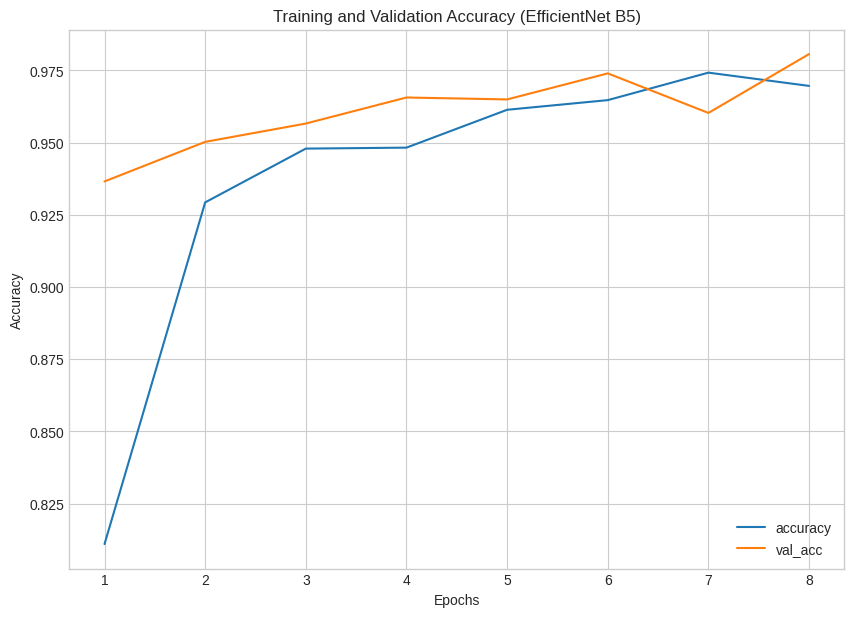

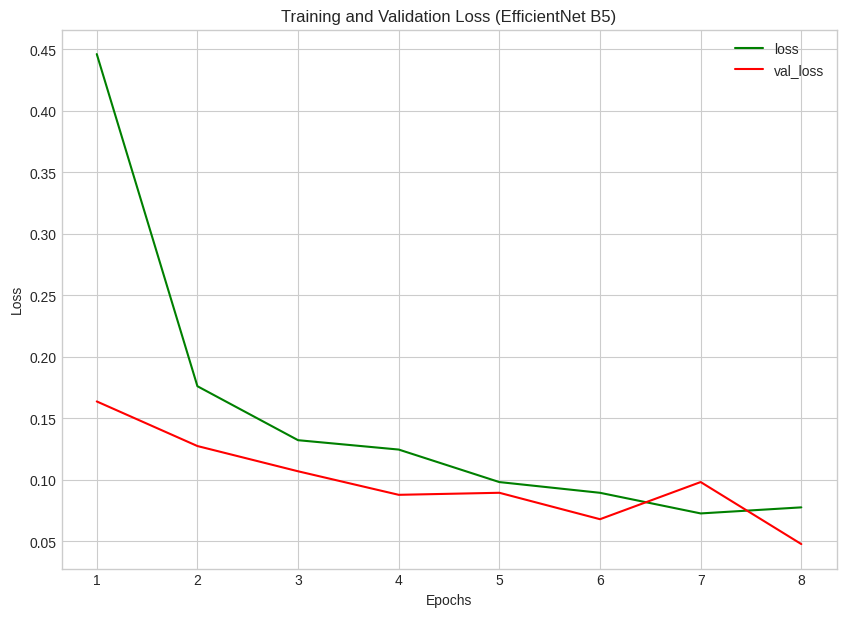

In [ ]:
# calculate model history
hist = history.history
hist.keys()
plt.style.use('seaborn-whitegrid')

epochs = range(1, len(hist['loss']) + 1)
acc = hist['accuracy']
loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']

# plot loss versus accuracy
plt.figure(figsize=(10, 7))
plt.title('Training and Validation Accuracy (EfficientNet B5)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend(loc='lower right')

# plot validation versus accuract
plt.figure(figsize=(10, 7))
plt.title('Training and Validation Loss (EfficientNet B5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [ ]:
model = history.model

In [ ]:
history.model.summary()# calculate result of validation data
scores = model.evaluate(val_data)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

In [ ]:
import tensorflow as tf

# train your model
#model = ...

# save the model to a file
tf.saved_model.save(model, '/content/gdrive/MyDrive/models/model_efb5/')


In [ ]:
y_hat = model.predict(val_data)
y_pred = np.argmax(y_hat, axis=1)

# print classification report
print(classification_report(val_data.classes, y_pred))

24/24 [==============================] - 33s 1s/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       994
           1       1.00      1.00      1.00      1000
           2       0.96      0.98      0.97      1000

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



Confusion matrix, without normalization


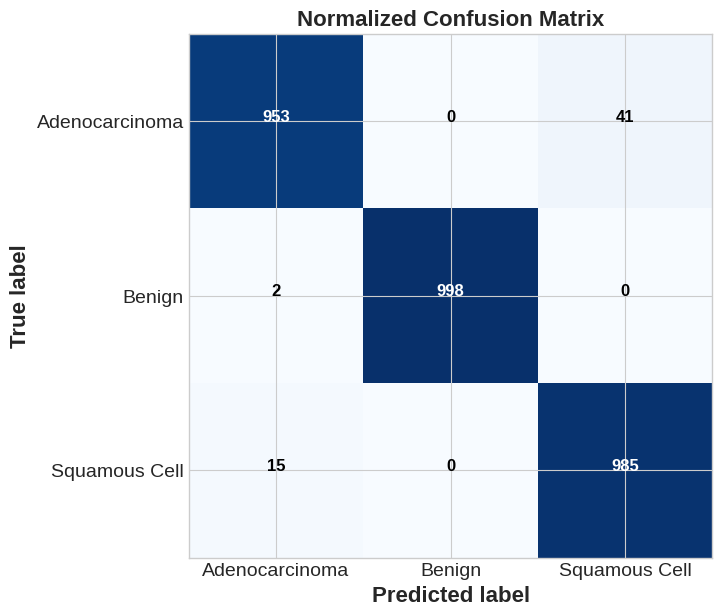

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# computing confusion matrix
cnf_matrix = confusion_matrix(val_data.classes, y_pred)
np.set_printoptions(precision=2)

# plotting non-normalized confusion matrix
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['Adenocarcinoma', 'Benign', 'Squamous Cell'],
                      normalize=False,
                      title='Normalized Confusion Matrix')
plt.show()

### **Train on Unbalanced dataset (no techniques)**

In [ ]:
%%time

#data_dir = '/content/gdrive/MyDrive/lung_data_full/'
data_dir = '/content/gdrive/MyDrive/imb_dataset50/'
# making a data split of 80-20
data = ImageDataGenerator(validation_split = .2)

# setting up the batch size
BATCH_SIZE = 32

# setting up the image size
X = Y = 224

# making training dataset
train_data = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

# making validation dataset
val_data = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 880 images belonging to 3 classes.
Found 218 images belonging to 3 classes.
CPU times: user 95.7 ms, sys: 16.9 ms, total: 113 ms
Wall time: 16.3 s


In [ ]:
# print label names
label =  {0: "lung adenocarcinoma", 1: "benign", 2: "squamous cell carcinoma"}
for t in label.keys():
    print(t, label[t])

0 lung adenocarcinoma
1 benign
2 squamous cell carcinoma


In [ ]:
# initializing efficientnet b7 cnn model
imb20_eff_5 = EfficientNetB5 (
        input_shape=(X, Y, 3),
        weights='imagenet',
        include_top=False
        )
# setting trainable to false    
imb20_eff_5.trainable = False

# global avg pooling layer
x = GlobalAveragePooling2D()(imb20_eff_5.output)
# flatten layer
x = Flatten()(x)
# fully connected layer 1
x = Dense(128, activation='relu')(x)
# fully connected layer 2
x = Dense(64, activation='relu')(x)

# outout layer
y = Dense(3, activation='softmax')(x) # since we have three outputs, we will use 3 neurons in last layer

# setting up y = f(x)
# tie it together
model_imb20_efb5 = Model(inputs=imb20_eff_5.input, 
              outputs=y)

# compiling the model
model_imb20_efb5.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



In [ ]:
# setting up early stopping to stop training when max acc is reached
# we are using validation loss as parameter for monitoring the training process

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3)

logger = CSVLogger('logs_efb5.csv', append=True)

EPOCHS = 30

# fitting the model to training data
history = model_imb20_efb5.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[callbacks, logger]
)

Epoch 1/30
26/26 [==============================] - 30s 531ms/step - loss: 0.3291 - accuracy: 0.9231 - val_loss: 0.1059 - val_accuracy: 0.9615
Epoch 2/30
26/26 [==============================] - 10s 378ms/step - loss: 0.0759 - accuracy: 0.9615 - val_loss: 0.0575 - val_accuracy: 0.9663
Epoch 3/30
26/26 [==============================] - 10s 369ms/step - loss: 0.0644 - accuracy: 0.9736 - val_loss: 0.0544 - val_accuracy: 0.9808
Epoch 4/30
26/26 [==============================] - 11s 436ms/step - loss: 0.0394 - accuracy: 0.9940 - val_loss: 0.0430 - val_accuracy: 0.9856
Epoch 5/30
26/26 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9880
Reached 99% accuracy so cancelling training!
26/26 [==============================] - 11s 420ms/step - loss: 0.0394 - accuracy: 0.9880 - val_loss: 0.0391 - val_accuracy: 0.9904


In [ ]:
y_hat = model_imb20_efb5.predict(val_data)
y_pred = np.argmax(y_hat, axis=1)

# print classification report
print(classification_report(val_data.classes, y_pred))

234/234 [==============================] - 69s 293ms/step
              precision    recall  f1-score   support

           0       0.93      0.52      0.67      2486
           1       0.81      1.00      0.90      2500
           2       0.79      0.95      0.87      2500

    accuracy                           0.83      7486
   macro avg       0.84      0.82      0.81      7486
weighted avg       0.84      0.83      0.81      7486



Confusion matrix, without normalization


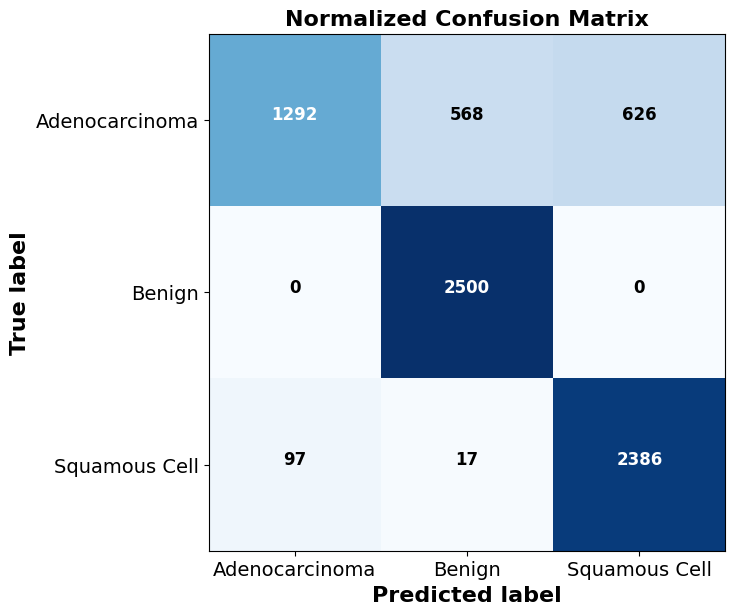

In [ ]:
# computing confusion matrix
cnf_matrix = confusion_matrix(val_data.classes, y_pred)
np.set_printoptions(precision=2)

# plotting non-normalized confusion matrix
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['Adenocarcinoma', 'Benign', 'Squamous Cell'],
                      normalize=False,
                      title='Normalized Confusion Matrix')
plt.show()

In [ ]:
# save the model to a file
tf.saved_model.save(model_imb20_efb5, '/content/gdrive/MyDrive/models/model_imb20_efb5')

### **weighted class**

In [ ]:
from sklearn.utils import class_weight

# compute the class weights using the training generator
y_train = train_data.classes
class_weights =  class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 7.333333333333333, 1: 0.36666666666666664, 2: 7.333333333333333}

In [ ]:
# setting up early stopping to stop training when max acc is reached
# we are using validation loss as parameter for monitoring the training process

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3)

logger = CSVLogger('logs_efb5.csv', append=True)

EPOCHS = 15
# fitting the model to training data
history = model_imb20_efb5.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[callbacks, logger]
)

Epoch 1/15
28/28 [==============================] - 29s 493ms/step - loss: 1.0955 - accuracy: 0.9102 - val_loss: 0.1333 - val_accuracy: 0.9771
Epoch 2/15
28/28 [==============================] - 12s 414ms/step - loss: 0.9122 - accuracy: 0.9318 - val_loss: 0.1093 - val_accuracy: 0.9587
Epoch 3/15
28/28 [==============================] - 11s 404ms/step - loss: 0.3737 - accuracy: 0.9682 - val_loss: 0.0743 - val_accuracy: 0.9679
Epoch 4/15
28/28 [==============================] - 11s 379ms/step - loss: 0.1951 - accuracy: 0.9886 - val_loss: 0.0818 - val_accuracy: 0.9679
Epoch 5/15
28/28 [==============================] - 11s 378ms/step - loss: 0.1439 - accuracy: 0.9784 - val_loss: 0.0810 - val_accuracy: 0.9725
Epoch 6/15
28/28 [==============================] - 11s 372ms/step - loss: 0.0929 - accuracy: 0.9909 - val_loss: 0.0609 - val_accuracy: 0.9771
Epoch 7/15
28/28 [==============================] - 10s 368ms/step - loss: 0.0692 - accuracy: 0.9966 - val_loss: 0.0574 - val_accuracy: 0.9817

188/188 [==============================] - 58s 310ms/step
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1988
           1       0.97      1.00      0.99      2000
           2       0.86      0.95      0.90      2000

    accuracy                           0.92      5988
   macro avg       0.93      0.92      0.92      5988
weighted avg       0.93      0.92      0.92      5988

Confusion matrix, without normalization


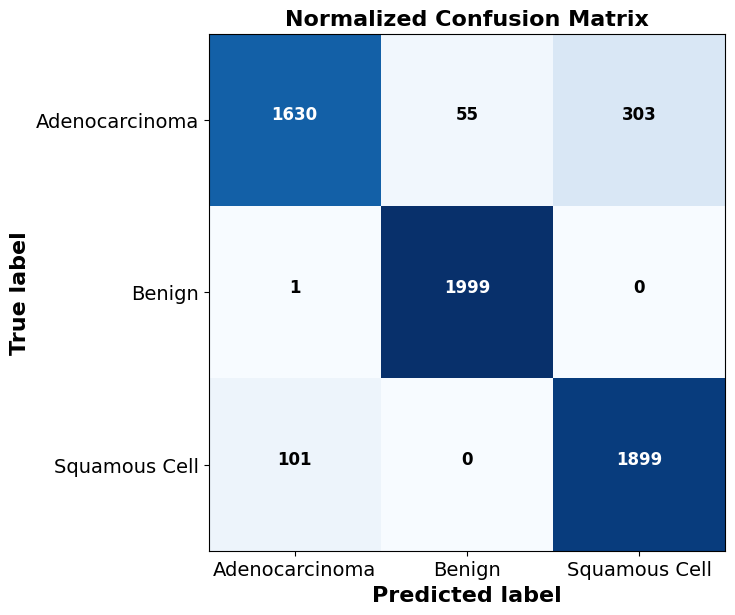

In [ ]:
y_hat = model_imb20_efb5.predict(val_data)
y_pred = np.argmax(y_hat, axis=1)

# print classification report
print(classification_report(val_data.classes, y_pred))

# computing confusion matrix
cnf_matrix = confusion_matrix(val_data.classes, y_pred)
np.set_printoptions(precision=2)

# plotting non-normalized confusion matrix
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['Adenocarcinoma', 'Benign', 'Squamous Cell'],
                      normalize=False,
                      title='Normalized Confusion Matrix')
plt.show()

### **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import Sequence

class SMOTEDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, smote_ratio=1.0):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.smote_ratio = smote_ratio
        self.smote = SMOTE(sampling_strategy=self.smote_ratio)
        self.indexes = np.arange(len(self.X))
        
    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = self.X[batch_indexes]
        batch_y = self.y[batch_indexes]
        
        if self.smote_ratio < 1.0:
            # Only apply SMOTE if the ratio is less than 1.0
            batch_X, batch_y = self.smote.fit_resample(batch_X, batch_y)
        
        return batch_X, batch_y


In [ ]:
train_generator = SMOTEDataGenerator(train_data, train_data.classes, batch_size=32, smote_ratio=0.5)
val_generator = SMOTEDataGenerator(val_data, val_data.classes, batch_size=32, smote_ratio=0.5)

#model.fit(train_generator, epochs=10)


In [ ]:
train_generator.X.samples

880

In [ ]:
# setting up early stopping to stop training when max acc is reached
# we are using validation loss as parameter for monitoring the training process

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3)

logger = CSVLogger('logs_efb5.csv', append=True)

EPOCHS = 5

# fitting the model to training data
history = model_imb20_efb5.fit(
    train_generator.X,
    validation_data=val_generator.X,
    epochs=EPOCHS,
    callbacks=[callbacks, logger]
)

Epoch 1/5
28/28 [==============================] - 11s 393ms/step - loss: 7.5389e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9817
Epoch 2/5
28/28 [==============================] - 12s 417ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0826 - val_accuracy: 0.9817
Epoch 3/5
28/28 [==============================] - 11s 382ms/step - loss: 7.9758e-04 - accuracy: 1.0000 - val_loss: 0.0920 - val_accuracy: 0.9817
Epoch 4/5
28/28 [==============================] - 11s 378ms/step - loss: 5.8550e-04 - accuracy: 1.0000 - val_loss: 0.1067 - val_accuracy: 0.9771
Epoch 5/5
28/28 [==============================] - 11s 373ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1340 - val_accuracy: 0.9725


188/188 [==============================] - 56s 298ms/step
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      1988
           1       0.91      1.00      0.95      2000
           2       0.80      0.98      0.88      2000

    accuracy                           0.88      5988
   macro avg       0.89      0.88      0.87      5988
weighted avg       0.89      0.88      0.87      5988

Confusion matrix, without normalization


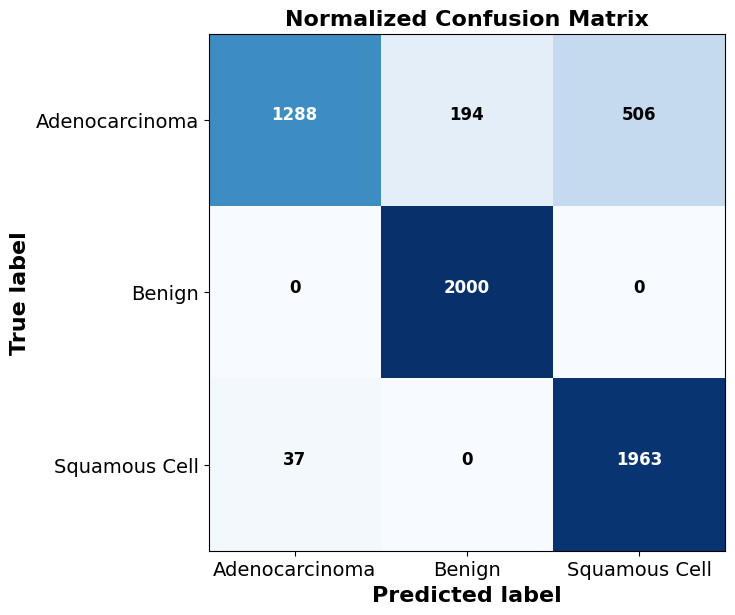

In [ ]:
y_hat = model_imb20_efb5.predict(val_data)
y_pred = np.argmax(y_hat, axis=1)

# print classification report
print(classification_report(val_data.classes, y_pred))

# computing confusion matrix
cnf_matrix = confusion_matrix(val_data.classes, y_pred)
np.set_printoptions(precision=2)

# plotting non-normalized confusion matrix
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['Adenocarcinoma', 'Benign', 'Squamous Cell'],
                      normalize=False,
                      title='Normalized Confusion Matrix')
plt.show()

In [ ]:
test_data = val_data

### **Ensemble method**

In [ ]:
%%time

data_dir = '/content/gdrive/MyDrive/lung_data_full/'
#data_dir = '/content/gdrive/MyDrive/imb_dataset50/'
# making a data split of 80-20
data = ImageDataGenerator(validation_split = .4)

# setting up the batch size
BATCH_SIZE = 32

# setting up the image size
X = Y = 224

# making training dataset
train_data = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

# making validation dataset
val_data = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 8984 images belonging to 3 classes.
Found 5988 images belonging to 3 classes.
CPU times: user 486 ms, sys: 93 ms, total: 579 ms
Wall time: 47.3 s


In [ ]:
# print label names
label =  {0: "lung adenocarcinoma", 1: "benign", 2: "squamous cell carcinoma"}
for t in label.keys():
    print(t, label[t])

0 lung adenocarcinoma
1 benign
2 squamous cell carcinoma


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB5

In [ ]:
from keras.layers import Input, Concatenate, Dense
from keras.models import Model
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB5

# Create input layer
input_layer = Input(shape=(224, 224, 3))

# Load and freeze the pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False)
for layer in resnet_model.layers:
    layer.trainable = False
    
vgg_model = VGG16(weights='imagenet', include_top=False)
for layer in vgg_model.layers:
    layer.trainable = False
    
efficientnet_model = EfficientNetB5(weights='imagenet', include_top=False)
for layer in efficientnet_model.layers:
    layer.trainable = False
    
# Get the output from each model
resnet_output = resnet_model(input_layer)
vgg_output = vgg_model(input_layer)
efficientnet_output = efficientnet_model(input_layer)

# Concatenate the outputs
concatenated = Concatenate()([resnet_output, vgg_output, efficientnet_output])

# global avg pooling layer
x = GlobalAveragePooling2D()(concatenated)
# flatten layer
x = Flatten()(x)
# fully connected layer 1
x = Dense(128, activation='relu')(x)
# fully connected layer 2
x = Dense(64, activation='relu')(x)

# outout layer
y = Dense(3, activation='softmax')(x) # since we have three outputs, we will use 3 neurons in last layer

# setting up y = f(x)
# tie it together
ensemble_model = Model(inputs=input_layer, 
              outputs=y)

#ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

# compiling the model
ensemble_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
ensemble_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, None, None,   23587712    ['input_48[0][0]']               
                                2048)                                                             
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_48[0][0]']               
                                512)                                                        

In [ ]:
# setting up early stopping to stop training when max acc is reached
# we are using validation loss as parameter for monitoring the training process

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3)

logger = CSVLogger('logs_efb5.csv', append=True)

EPOCHS = 15

# fitting the model to training data
history = ensemble_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[callbacks, logger]
)

Epoch 1/15
28/28 [==============================] - 703s 24s/step - loss: 1.6149 - accuracy: 0.8523 - val_loss: 0.3535 - val_accuracy: 0.9495
Epoch 2/15
28/28 [==============================] - 15s 531ms/step - loss: 0.2605 - accuracy: 0.9239 - val_loss: 0.2773 - val_accuracy: 0.9587
Epoch 3/15
28/28 [==============================] - 15s 534ms/step - loss: 0.2352 - accuracy: 0.9545 - val_loss: 0.0456 - val_accuracy: 0.9771
Epoch 4/15
28/28 [==============================] - 15s 533ms/step - loss: 0.0565 - accuracy: 0.9761 - val_loss: 0.0690 - val_accuracy: 0.9771
Epoch 5/15
28/28 [==============================] - 15s 541ms/step - loss: 0.0190 - accuracy: 0.9920 - val_loss: 0.1182 - val_accuracy: 0.9725
Epoch 6/15
28/28 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9727
Reached 99% accuracy so cancelling training!
28/28 [==============================] - 15s 535ms/step - loss: 0.0847 - accuracy: 0.9727 - val_loss: 0.0178 - val_accuracy: 0.9954


188/188 [==============================] - 2688s 14s/step
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1988
           1       0.96      1.00      0.98      2000
           2       0.91      0.94      0.93      2000

    accuracy                           0.94      5988
   macro avg       0.94      0.94      0.94      5988
weighted avg       0.94      0.94      0.94      5988

Confusion matrix, without normalization


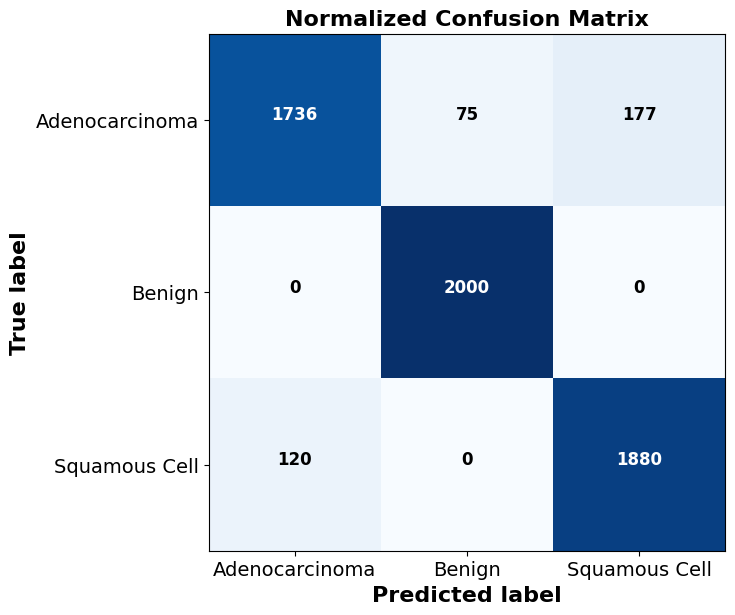

In [ ]:
y_hat = ensemble_model.predict(val_data)
y_pred = np.argmax(y_hat, axis=1)

# print classification report
print(classification_report(val_data.classes, y_pred))

# computing confusion matrix
cnf_matrix = confusion_matrix(val_data.classes, y_pred)
np.set_printoptions(precision=2)

# plotting non-normalized confusion matrix
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['Adenocarcinoma', 'Benign', 'Squamous Cell'],
                      normalize=False,
                      title='Normalized Confusion Matrix')
plt.show()